In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_context('paper')
import datetime
sns.set_style('whitegrid')



from scipy import stats

from __future__ import division
import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFECV

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier


from sklearn.metrics import roc_curve

In [2]:
df1 = pd.read_csv('takehome_user_engagement.csv',parse_dates=['time_stamp'] )

In [3]:
df1.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [5]:
len(df1.user_id.value_counts())

8823

In [6]:
df2 = pd.read_csv('takehome_users.csv', parse_dates=['creation_time'],infer_datetime_format=True )

In [7]:
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [9]:
df2['last_session_creation_time'] = pd.to_datetime(df2['last_session_creation_time'], unit='s')

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [11]:
df1.time_stamp.min()

Timestamp('2012-05-31 08:20:06')

In [12]:
df1.time_stamp.max()

Timestamp('2014-06-06 14:58:50')

In [13]:
df1_ = df1.set_index('time_stamp')

In [14]:
active = df1_.groupby(['user_id'])['visited'].resample('W').count()

In [15]:
act = pd.DataFrame(active).reset_index()

In [16]:
new_df = act[act.visited==3]
new_df.head()

,user_id,time_stamp,visited
13,2,2014-02-09,3
33,10,2013-03-03,3
39,10,2013-04-14,3
41,10,2013-04-28,3
44,10,2013-05-19,3


In [17]:
active_users = new_df.user_id.unique()
len(active_users)

1405

In [18]:
df2.head(1)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0


In [19]:
df2_unique = (df2.object_id.unique())

In [20]:
len(df2_unique)

12000

In [21]:
len(np.intersect1d(active_users, df2_unique))

1405

In [22]:
df2['adopted_user'] = np.nan

In [23]:
df2['adopted_user'] = df2.loc[df2.object_id.isin(active_users)]

In [24]:
df2['adopted_user'] = df2['adopted_user'].fillna(0)

In [25]:
def adopted(var):
    if var ==0:
        return 0
    else:
        return 1

In [26]:
df2['adopted_user'] = df2['adopted_user'].apply(adopted)

In [27]:
df2.describe()

/Users/macbook/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145,0.117083
std,3464.24595,0.432742,0.356432,124.056723,3383.761968,0.321533
min,1.00000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,3000.75000,0.000000,0.000000,29.000000,NaN,0.000000
50%,6000.50000,0.000000,0.000000,108.000000,NaN,0.000000
75%,9000.25000,0.000000,0.000000,238.250000,NaN,0.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000,1.000000


In [28]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted_user                  12000 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(5), object(3)
memory usage: 1.0+ MB


In [29]:
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


## Percentage of Adopted Users is 11.70%

Limitations: I was not able to check if the user logged in on 3 separate days

In [30]:
df2.adopted_user.value_counts()[1] / len(df2.adopted_user) * 100

11.708333333333334

In [31]:
df2['invited_by_user'] = df2.invited_by_user_id.fillna(0).apply(adopted)

In [32]:
df2.invited_by_user.value_counts()

1    6417
0    5583
Name: invited_by_user, dtype: int64

In [33]:
df2.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [34]:
dummy_creation = pd.get_dummies(data=df2['creation_source'])

In [35]:
data = pd.concat([df2, dummy_creation], axis=1)

In [36]:
data.head()


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited_by_user,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1,1.0,0.0,0.0,0.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,0.0,1.0,0.0,0.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1,0.0,1.0,0.0,0.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1,1.0,0.0,0.0,0.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1,1.0,0.0,0.0,0.0,0.0


In [37]:
new_df = data[['opted_in_to_mailing_list','enabled_for_marketing_drip','invited_by_user',
     'GUEST_INVITE',
 'ORG_INVITE',
 'PERSONAL_PROJECTS',
 'SIGNUP',
 'SIGNUP_GOOGLE_AUTH', 'adopted_user']]

In [38]:
new_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,adopted_user
0,1,0,1,1.0,0.0,0.0,0.0,0.0,0
1,0,0,1,0.0,1.0,0.0,0.0,0.0,1
2,0,0,1,0.0,1.0,0.0,0.0,0.0,0
3,0,0,1,1.0,0.0,0.0,0.0,0.0,0
4,0,0,1,1.0,0.0,0.0,0.0,0.0,0


# Predictive Modeling:


Invited by user, Guess Invite, Personal Projects, and Sign Up Google Authorization are the metrics that are the most correlated with user adoption. Of the adopted users, there are 3% more users who signed up through google authorization and guest invites than those who did not. In comparison to the users who signed up because of personal projects, where there are 5% more of users who did not sign up. However, the number of users invited by a user are 1% more in the adopted user group. 

When performing the feature selection, the optimal number of features for the Logistic Regression model shows that all 8 are important and accuracy as the highest metric. The Decision Tree classifier with the feature importances show that Personal Projects, Organization and Enabled for Marketing Drip as the top 3 most important features. In contrast to the Extra Trees Classifier which shows Personal Projects, Guest Invite, and Signup as the top 3 most important features. 

Initially, the Logistic Regression and Decision Tree model was used to classify user adoption, but the two models both had the value of zero for True Positives and the False Positives. This causes the F1 score, when classified as “Adopted” to be zero. Both models had a high accuracy at 87% and 88% respectively. In order to address this issue, despite the high accuracy score, the SMOTE resampling algorithm was used in order to up-sample the minority “adopted” class. Upon doing so, both models saw a decrease in accuracy at 60.8% and 46.4% respectively. However, there are no zeros in the confusion matrix for the True Positives and False Positives. The Decision Tree model was able to correctly classify 54% of the users and 80% of the predicted users were classified to their respected labels. Whereas in the Logistic Regression model, where 61% of the labeled users were correctly classified and a 78% precision of the classification. Also, the odds ratio calculated showed that the Organization Invite and Personal Projects were more likely in non-adopted users. 


In [39]:
X = new_df.drop('adopted_user', axis=1)
y = new_df.adopted_user

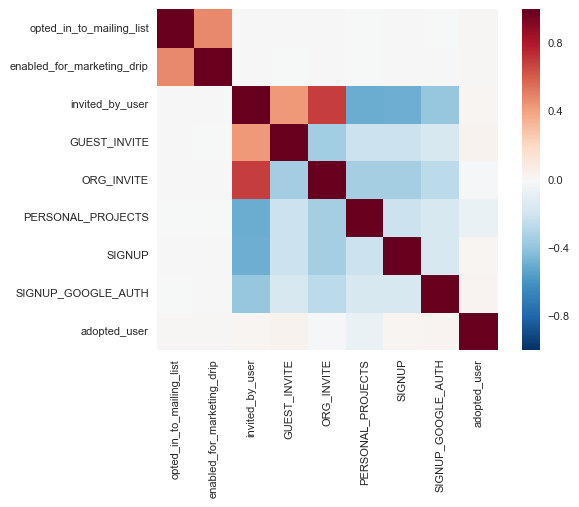

In [40]:
sns.heatmap(new_df.corr(),square=True, )

In [41]:
new_df.columns.tolist()

['opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'invited_by_user',
 'GUEST_INVITE',
 'ORG_INVITE',
 'PERSONAL_PROJECTS',
 'SIGNUP',
 'SIGNUP_GOOGLE_AUTH',
 'adopted_user']

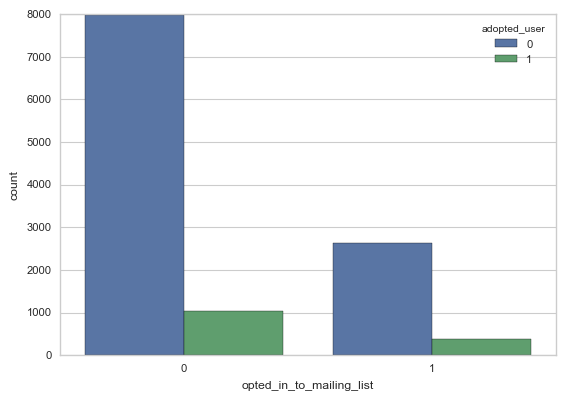

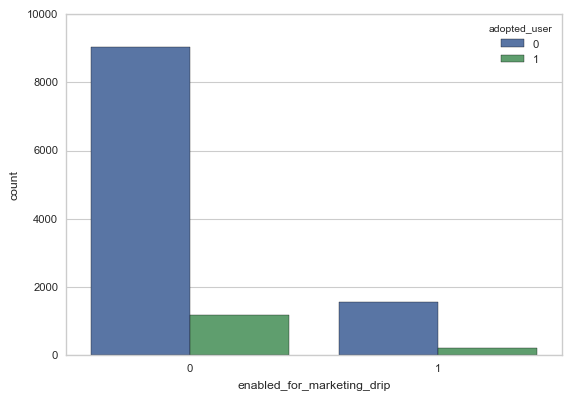

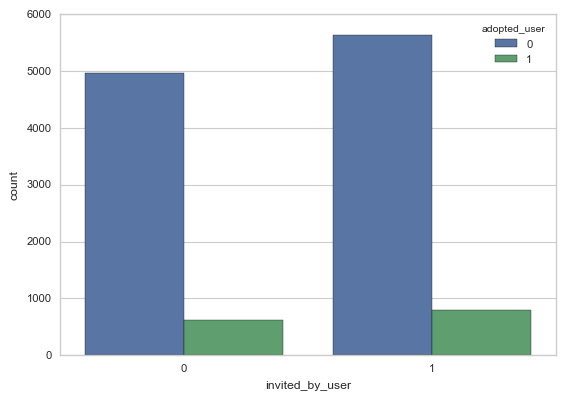

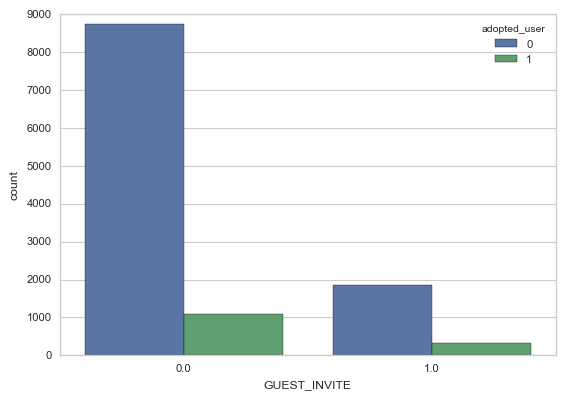

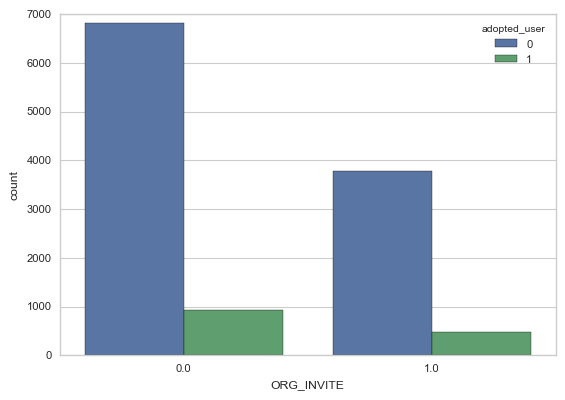

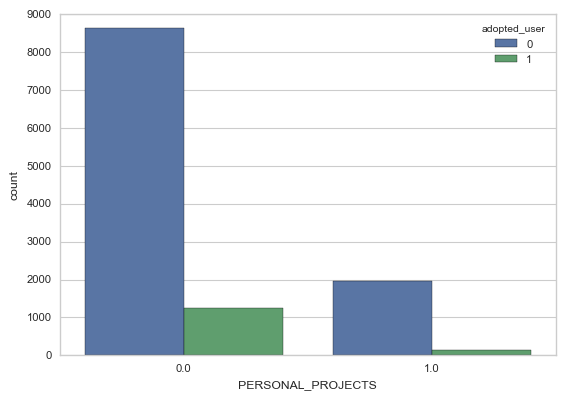

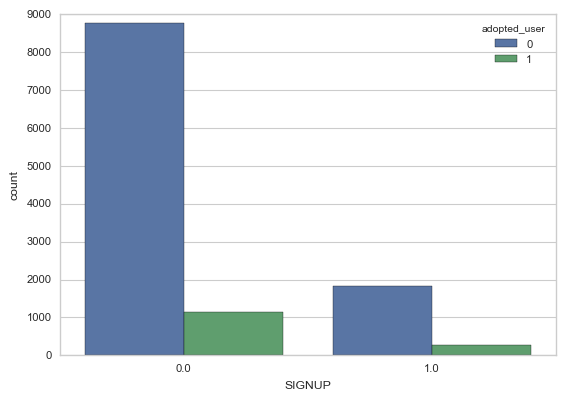

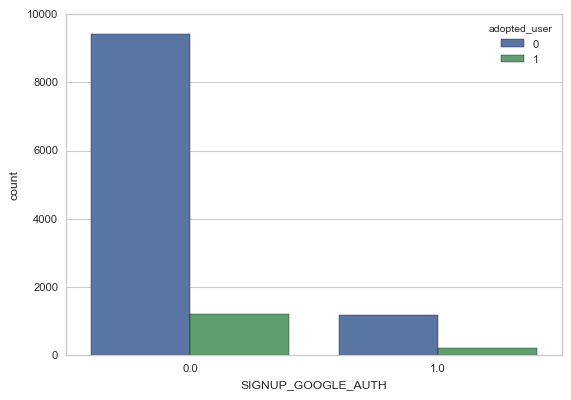

In [42]:
cols = ['opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'invited_by_user',
 'GUEST_INVITE',
 'ORG_INVITE',
 'PERSONAL_PROJECTS',
 'SIGNUP',
 'SIGNUP_GOOGLE_AUTH']

for c in cols:
    sns.countplot(data=new_df, x=c, hue='adopted_user')
    plt.show()

In [43]:
pd.crosstab(index=new_df['adopted_user'], columns=new_df['SIGNUP'])

SIGNUP,0.0,1.0
adopted_user,,
0,8776,1819
1,1137,268


In [44]:
stats.chi2_contingency(pd.crosstab(index=new_df['adopted_user'], columns=new_df['SIGNUP']))

(3.006293985385458,
 0.08294172465397591,
 1,
 array([[8752.35291667, 1842.64708333],
        [1160.64708333,  244.35291667]]))

In [45]:
stats.fisher_exact(pd.crosstab(index=new_df['adopted_user'], columns=new_df['SIGNUP']))

(1.1372036497384443, 0.07837096155582357)

In [46]:
def stats_analysis(col):
    
    print (str(col))
    cont_table = pd.crosstab(index=new_df['adopted_user'], columns=new_df[col])
    
    chi_2 = stats.chi2_contingency(cont_table)
    chi2, pval, dof, expected = chi_2
    print ('Chi2 Results:')
    print ('Chi2: {}'.format(chi2))
    print ('P-value: {}'.format(pval))
    
    print('\t')
    fisher = stats.fisher_exact(cont_table)
    oddsratio, p_val = fisher
    print('Fisher\'s Results:')
    print ('Odds Ratio: {}'.format(oddsratio))
    print ('P-Value: {}'.format(p_val))
    print('\t')
    print ('--------------')

In [47]:
for col in cols:
    stats_analysis(col)

opted_in_to_mailing_list
Chi2 Results:
Chi2: 1.88996783419
P-value: 0.169205549688
	
Fisher's Results:
Odds Ratio: 1.09504431562
P-Value: 0.158494398046
	
--------------
enabled_for_marketing_drip
Chi2 Results:
Chi2: 0.866700606008
P-value: 0.351870342681
	
Fisher's Results:
Odds Ratio: 1.07873752901
P-Value: 0.339051305134
	
--------------
invited_by_user
Chi2 Results:
Chi2: 4.9729318839
P-value: 0.0257469682845
	
Fisher's Results:
Odds Ratio: 1.13783000286
P-Value: 0.0245428675578
	
--------------
GUEST_INVITE
Chi2 Results:
Chi2: 17.8804843561
P-value: 2.35220881425e-05
	
Fisher's Results:
Odds Ratio: 1.34203104702
P-Value: 2.94879432395e-05
	
--------------
ORG_INVITE
Chi2 Results:
Chi2: 1.08782385586
P-value: 0.29695387546
	
Fisher's Results:
Odds Ratio: 0.93787650926
P-Value: 0.285555007314
	
--------------
PERSONAL_PROJECTS
Chi2 Results:
Chi2: 56.3462298012
P-value: 6.07696870332e-14
	
Fisher's Results:
Odds Ratio: 0.509301982469
P-Value: 1.92216950942e-15
	
--------------
SIGNUP

In [48]:
#it lookslike invited by user, guess invite, personal projects, and sign up google auth
# are the most correlated with the adopted user

In [49]:
#using the two proportion Z-test 

In [50]:
def twoporZtest (x1,x2, n1, n2):
    p1 = x1 / n1
    p2 = x2 / n2
    
    p_hat = (x1 + x2) / (n1 + n2)
    SEM = np.sqrt(p_hat* (1-p_hat) * ((1/n1) + (1/n2)))
    z = (p1-p2) / SEM
    p_val = stats.norm.sf(abs(z))
    diff_prop = p1-p2
    m = 1.96 * np.sqrt(  ((p1 * (1-p1))/n1)  +   ((p2 * (1-p2))/n2)    )
    CI = (diff_prop - m), (diff_prop + m)
    phi1 = 2 * np.arcsin(np.sqrt(p1))
    phi2 = 2 * np.arcsin(np.sqrt(p2))
    CH = abs(phi1 - phi2)
    
    print ("z: {}".format(z))
    print ("p-value: {}".format(p_val))
    print ("CI: {}".format(CI))
    print ("proportion difference: {}".format(diff_prop))
    print ("p1: {}".format(p1))
    print ("p2: {}".format(p2))
    print ('Cohens H = {}'.format(CH))

In [51]:
important_cols = ['SIGNUP_GOOGLE_AUTH','PERSONAL_PROJECTS','GUEST_INVITE','invited_by_user']

for cols in important_cols:
    print(pd.crosstab(index=new_df['adopted_user'], columns=new_df[cols], margins=True))
    print ('\t')
    
    t = pd.crosstab(index=new_df['adopted_user'], columns=new_df[cols], margins=True)
    x1 = t[1][1]
    n1 = t[1][2]
    x2 = t[0][1]
    n2 = t[0][2]
    
    twoporZtest(x1, x2, n1, n2)
    print('\t')
    print ('----------')

SIGNUP_GOOGLE_AUTH    0.0   1.0    All
adopted_user                          
0                    9410  1185  10595
1                    1205   200   1405
All                 10615  1385  12000
	
z: 3.36236368184
p-value: 0.000386391355874
CI: (0.011414805746348487, 0.05035664702040926)
proportion difference: 0.0308857263834
p1: 0.14440433213
p2: 0.113518605747
Cohens H = 0.0923063936589
	
----------
PERSONAL_PROJECTS   0.0   1.0    All
adopted_user                        
0                  8630  1965  10595
1                  1259   146   1405
All                9889  2111  12000
	
z: -7.54369747378
p-value: 2.28415109089e-14
CI: (-0.0708132586408817, -0.04549002423676745)
proportion difference: -0.0581516414388
p1: 0.0691615348176
p2: 0.127313176256
Cohens H = 0.19746987983
	
----------
GUEST_INVITE   0.0   1.0    All
adopted_user                   
0             8743  1852  10595
1             1094   311   1405
All           9837  2163  12000
	
z: 4.26546339349
p-value: 9.97438608

In [52]:
t = pd.crosstab(index=new_df['adopted_user'], columns=new_df['PERSONAL_PROJECTS'], margins=True)

In [53]:
new_df.SIGNUP_GOOGLE_AUTH.value_counts(normalize=True)

0.0    0.884583
1.0    0.115417
Name: SIGNUP_GOOGLE_AUTH, dtype: float64

In [54]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
invited_by_user               12000 non-null int64
GUEST_INVITE                  12000 non-null float64
ORG_INVITE                    12000 non-null float64
PERSONAL_PROJECTS             12000 non-null float64
SIGNUP                        12000 non-null float64
SIGNUP_GOOGLE_AUTH            12000 non-null float64
adopted_user                  12000 non-null int64
dtypes: float64(5), int64(4)
memory usage: 843.8 KB


In [55]:
new_df.GUEST_INVITE.value_counts()

0.0    9837
1.0    2163
Name: GUEST_INVITE, dtype: int64

In [56]:
new_df.invited_by_user.value_counts()

1    6417
0    5583
Name: invited_by_user, dtype: int64

In [57]:
X = new_df.drop('adopted_user', axis=1)
y = new_df.adopted_user

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30)

In [59]:
print(cross_val_score(LogisticRegression(), X_train, y_train, cv=10).mean())
print(cross_val_score(LogisticRegression(), X_test, y_test, cv=10).mean())

0.8846429663037396
0.8788912294419282


In [60]:
def plot_nfeat(model):
    """preforms a recursive feature elimination with cross validation, using 
    whatever scoring you like"""
    score_metric = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
    f, ax = plt.subplots(sharey=True)
    for s in score_metric:
        selector = RFECV(model, step=1, cv=StratifiedKFold(10), scoring=s)
        selector.fit(X,y)                
        print ('Scoring: {}'.format(s))
        print ('Optimal Number of Features = {}'.format(selector.n_features_))
        headers = ['Name', 'Ranking']
        values = sorted(zip(X.columns, selector.ranking_))
        top_feat = filter(lambda x:x[:][1]==1, values)
    
        top_feats = []
        top_feats.append(top_feat)
        unique_feats = np.unique((np.array(top_feats)))
        top_features = unique_feats.tolist()
        print (top_features[1:])
        print ('\t')
        
        
        plt.xlabel('Number of Features Selected')
        plt.ylabel('Cross Validation Score')
        plt.plot(range(1,len(selector.grid_scores_)+1), selector.grid_scores_, label=s)
        plt.title('Optimal Number of Features')
        plt.legend()

Scoring: accuracy
Optimal Number of Features = 8
['GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH', 'enabled_for_marketing_drip', 'invited_by_user', 'opted_in_to_mailing_list']
	
Scoring: roc_auc
Optimal Number of Features = 3
['ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP']
	


/Users/macbook/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Scoring: f1
Optimal Number of Features = 8
['GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH', 'enabled_for_marketing_drip', 'invited_by_user', 'opted_in_to_mailing_list']
	


/Users/macbook/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Scoring: precision
Optimal Number of Features = 8
['GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH', 'enabled_for_marketing_drip', 'invited_by_user', 'opted_in_to_mailing_list']
	
Scoring: recall
Optimal Number of Features = 8
['GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH', 'enabled_for_marketing_drip', 'invited_by_user', 'opted_in_to_mailing_list']
	


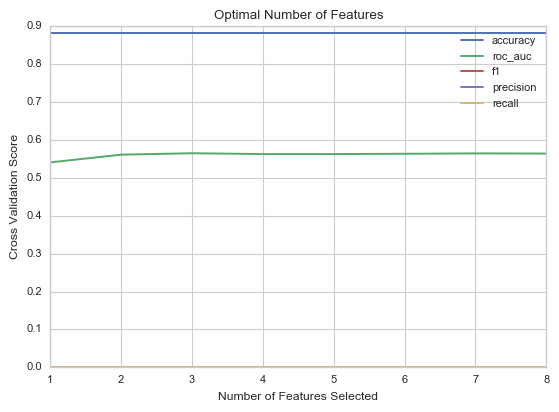

In [61]:
plot_nfeat(LogisticRegression())

Scoring: accuracy
Optimal Number of Features = 8
['GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH', 'enabled_for_marketing_drip', 'invited_by_user', 'opted_in_to_mailing_list']
	
Scoring: roc_auc
Optimal Number of Features = 2
['ORG_INVITE', 'PERSONAL_PROJECTS']
	
Scoring: f1
Optimal Number of Features = 8
['GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH', 'enabled_for_marketing_drip', 'invited_by_user', 'opted_in_to_mailing_list']
	
Scoring: precision
Optimal Number of Features = 8
['GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH', 'enabled_for_marketing_drip', 'invited_by_user', 'opted_in_to_mailing_list']
	
Scoring: recall
Optimal Number of Features = 8
['GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH', 'enabled_for_marketing_drip', 'invited_by_user', 'opted_in_to_mailing_list']
	


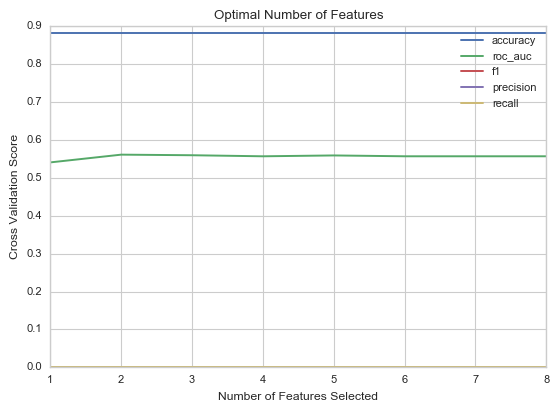

In [71]:
plot_nfeat(DecisionTreeClassifier())

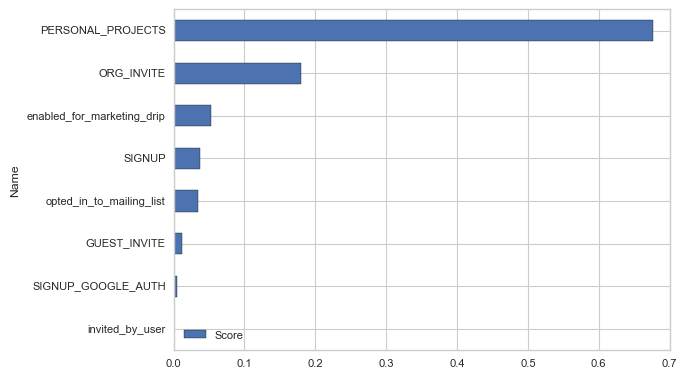

In [89]:
clf = DecisionTreeClassifier()
clf.fit(X,y)
header = ['Name', 'Score']
values = sorted(zip(X.columns, clf.feature_importances_))
pd.DataFrame(columns=header, data=values).sort_values('Score').set_index('Name').plot(kind='barh')

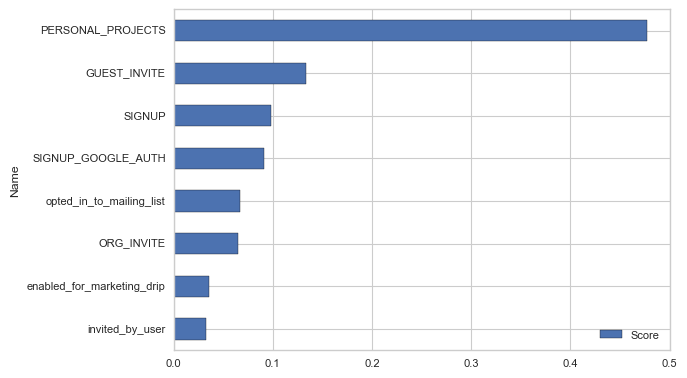

In [218]:
clf = ExtraTreesClassifier()
clf.fit(X,y)
values = sorted(zip(X.columns, clf.feature_importances_))
pd.DataFrame(values, columns=header).set_index('Name').sort_values('Score').plot(kind='barh')

In [62]:
logit_params = {'C': [0.001,0.01, 0.1, 1, 10, 100]}
model_cv = GridSearchCV(LogisticRegression(),param_grid=logit_params, cv=10,scoring='accuracy')

model_cv.fit(X_train,y_train)
print ('best score: {}'.format(model_cv.best_score_))
print('Test Data Score: {}'.format(model_cv.score(X_test, y_test)))

print('best params:{}'.format(model_cv.best_params_))
y_pred = model_cv.predict(X_test)
print (classification_report(y_test, y_pred,))
print (confusion_matrix(y_test,y_pred))

best score: 0.884642857143
Test Data Score: 0.878888888889
best params:{'C': 0.001}
             precision    recall  f1-score   support

          0       0.88      1.00      0.94      3164
          1       0.00      0.00      0.00       436

avg / total       0.77      0.88      0.82      3600

[[3164    0]
 [ 436    0]]


/Users/macbook/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
bestmodel = model_cv.best_estimator_

In [64]:
bestmodel.fit(X_train/np.std(X_train,0), y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [196]:
print (bestmodel.coef_)

[[ 0.02574733 -0.01829432  0.03781208  0.06567869 -0.02786661 -0.16791398
   0.03922694  0.07585899]]


In [249]:
values = (zip(X.columns, np.exp(bestmodel.coef_.reshape(8,))))
pd.DataFrame(data=values, columns=['Col','Odds'])

,Col,Odds
0,opted_in_to_mailing_list,1.047694
1,enabled_for_marketing_drip,1.023383
2,invited_by_user,1.052647
3,GUEST_INVITE,1.079427
4,ORG_INVITE,0.975190
5,PERSONAL_PROJECTS,0.802796
6,SIGNUP,1.077039
7,SIGNUP_GOOGLE_AUTH,1.063859


In [250]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30)
sm = SMOTE(random_state=12, ratio='minority')
#changing the X_train and y_train
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [251]:
y_train.value_counts()

0    7435
1     965
Name: adopted_user, dtype: int64

In [252]:
np.unique(y_train_res, return_counts=True)

(array([0, 1]), array([7435, 7435]))

In [255]:
def smote_pipeline(model, params):
    """fixes the class imbalance issue using SMOTE
    GridSearchCV uss 10 fold CV for each scoring metric
    """
    scoring = ['accuracy', 'roc_auc']
    
    #gather data for each scoring metric
    for score_metric in scoring:
        model_cv = GridSearchCV(model, param_grid=params, cv=StratifiedKFold(10), scoring=score_metric)
        model_cv.fit(X_train_res, y_train_res)
    
        print (str(score_metric))
        print ('Best Score for Training Data: {}'.format(model_cv.best_score_))
        print(model_cv.best_params_)


        y_pred = model_cv.predict(X_test)

        print('Test Data Score: {}'.format(model_cv.score(X_test, y_test)))

        print (classification_report(y_test, y_pred))
        print (confusion_matrix(y_test,y_pred))
        best_model = model_cv.best_estimator_

        print('Sanity Check: {}'.format(best_model.fit(X_train_res, y_train_res).score(X_test, y_test)))
        print ('\t')
        
        values = (zip(X.columns, np.exp(best_model.coef_.reshape(8,))))
        headers = ['Column','Odds']
        d_f = pd.DataFrame(data=values, columns=headers)
        print (d_f)
        print ('Intercept:{}'.format(best_model.intercept_))
        print ('\t')
        
        y_proba = model_rv.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        plt.plot([0,1], [0,1], 'k--')
        plt.plot(fpr, tpr, label='SVM')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

accuracy
Best Score for Training Data: 0.556624075319
{'C': 0.01}
Test Data Score: 0.608888888889
             precision    recall  f1-score   support

          0       0.89      0.64      0.74      3160
          1       0.13      0.41      0.20       440

avg / total       0.79      0.61      0.68      3600

[[2013 1147]
 [ 261  179]]
Sanity Check: 0.608888888889
	
                       Column      Odds
0    opted_in_to_mailing_list  0.994155
1  enabled_for_marketing_drip  1.102923
2             invited_by_user  1.110064
3                GUEST_INVITE  1.237759
4                  ORG_INVITE  0.896834
5           PERSONAL_PROJECTS  0.622849
6                      SIGNUP  1.028650
7          SIGNUP_GOOGLE_AUTH  1.333208
Intercept:[-0.05319855]
	


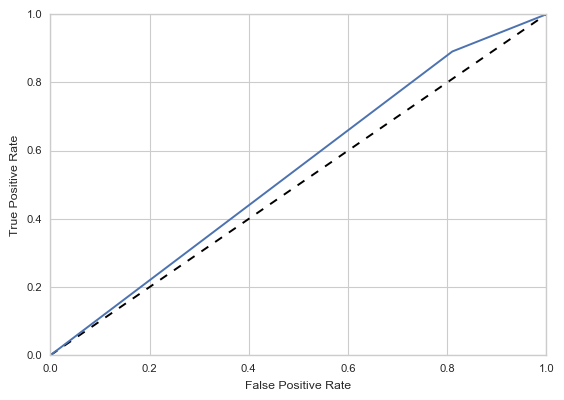

roc_auc
Best Score for Training Data: 0.575042348452
{'C': 0.1}
Test Data Score: 0.54643627733
             precision    recall  f1-score   support

          0       0.89      0.64      0.74      3160
          1       0.13      0.41      0.20       440

avg / total       0.79      0.61      0.68      3600

[[2013 1147]
 [ 261  179]]
Sanity Check: 0.608888888889
	
                       Column      Odds
0    opted_in_to_mailing_list  0.984949
1  enabled_for_marketing_drip  1.130177
2             invited_by_user  1.120304
3                GUEST_INVITE  1.264474
4                  ORG_INVITE  0.885985
5           PERSONAL_PROJECTS  0.574494
6                      SIGNUP  1.037672
7          SIGNUP_GOOGLE_AUTH  1.410984
Intercept:[-0.05939784]
	


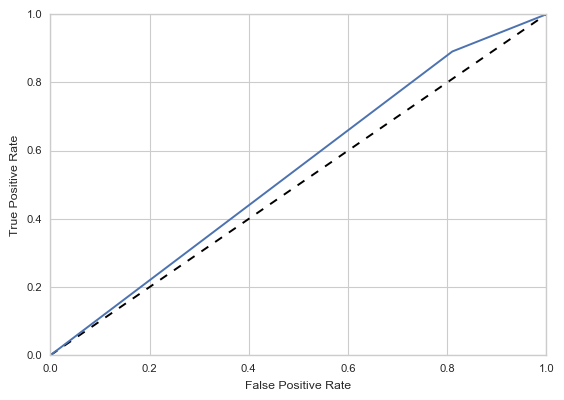

In [256]:
smote_pipeline(LogisticRegression(), logit_params)

In [226]:
DT_params = {'max_depth':[1,2,4,6,8], 'min_samples_leaf': [0.10, 0.30, 0.40, 0.50]}

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30)

model_rv = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=DT_params, cv=10)
model_rv.fit(X_train, y_train)
print ('Best Params:{}'.format(model_rv.best_params_))
print ('Best Score: {}'.format(model_rv.best_score_))

Best Params:{'max_depth': 6, 'min_samples_leaf': 0.5}
Best Score: 0.883928571429


In [228]:
y_pred = model_rv.predict(X_test)
model_rv.score(X_test, y_test)

0.8805555555555555

In [229]:
model_rv.score(X_train, y_train)

0.8839285714285714

In [230]:
print (classification_report(y_test, y_pred))
print (confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      1.00      0.94      3170
          1       0.00      0.00      0.00       430

avg / total       0.78      0.88      0.82      3600

[[3170    0]
 [ 430    0]]


In [109]:
#let's try upsampling the minority class and see if we get any positives

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30)

sm = SMOTE(random_state=12, ratio='minority')
#changing the X_train and y_train
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [233]:
model_rv = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=DT_params, cv=10)
model_rv.fit(X_train_res, y_train_res)
print ('Best Params:{}'.format(model_rv.best_params_))
print ('Best Score: {}'.format(model_rv.best_score_))
print ('Training Score: {}'.format(model_cv.score(X_train_res, y_train_res)))
print ('Test Score" {}'.format(model_cv.best_estimator_.fit(X_train_res, y_train_res).score(X_test, y_test)))

Best Params:{'max_depth': 1, 'min_samples_leaf': 0.1}
Best Score: 0.546250168305
Training Score: 0.552039854585
Test Score" 0.464444444444


In [143]:
y_pred = model_rv.predict(X_test)
print (classification_report(y_test, y_pred))
print (confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.90      0.54      0.67      3146
          1       0.15      0.57      0.24       454

avg / total       0.80      0.54      0.62      3600

[[1692 1454]
 [ 194  260]]


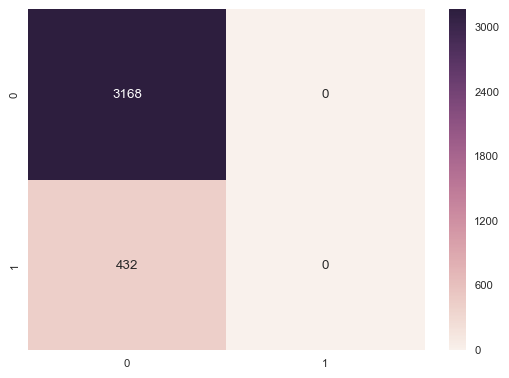

In [234]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm,annot=True ,ax = ax,fmt='g');

In [238]:
y_proba = model_rv.predict_proba(X_test)[:,1]

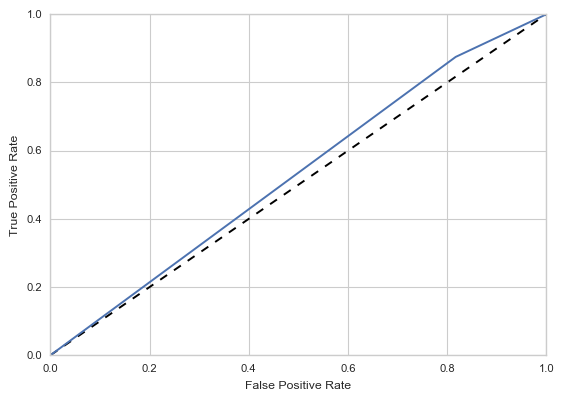

In [239]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')